# TSP Genetic Algorithm

Here, I use a genetic algorithm to solve the travelling salesman problem. I will only consider closed loops in symmetric graphs.
 
Let's start by generating some graphs, which will be done by selecting points at random from the unit square and computing the Euclidean distances. This particular choice of metric has the advantage that the quality of a potential solution can be judged by eye. To further facilitate such jugements, we will frequently refer to the particular case of points distributed on a circle, the shortest cycle for which runs obviously along the perimeter.

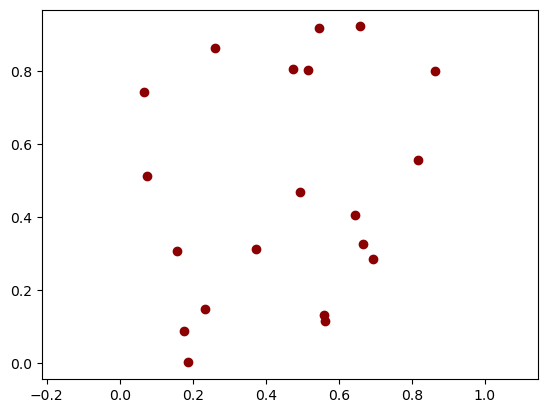

In [80]:
import numpy as np
import random
import matplotlib.pyplot as plt

class Graph():
    def __init__(self, size):
        self.size = size
        self.x = np.random.random(size)
        self.y = np.random.random(size)  
        self.d = np.zeros((size,size))
        for i in range(size):
            for j in range(size):
                self.d[i,j] = np.sqrt( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )
        
    def show(self):
        plt.scatter(self.x,self.y, color = "darkred")
        plt.axis('equal')

    def plot_cycle(self, c_list, color = "lightblue"):
        self.show()
        for i in range(-1,len(c_list)-1):
            plt.plot([ self.x[c_list[i]], self.x[c_list[i+1]] ], [ self.y[c_list[i]], self.y[c_list[i+1]] ], color=color)

    def cycle_length(self, c_list):
        l = 0
        for i in range(-1,len(c_list)-1):
            l += self.d[ c_list[i], c_list[i+1] ]
        return l

class Circular_Graph(Graph):
    def __init__(self,size):
        phi = 2*np.pi*np.random.random(size)
        self.x = 0.5+0.25*np.cos(phi)
        self.y = 0.5+0.25*np.sin(phi)
        self.d = np.zeros((size,size))
        for i in range(size):
            for j in range(size):
                self.d[i,j] = np.sqrt( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )
                
Graph(20).show()

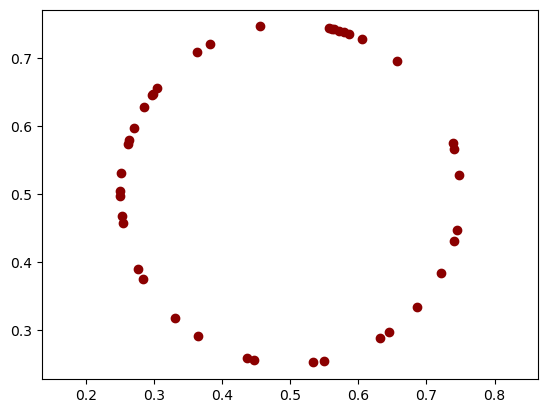

In [81]:
Circular_Graph(40).show()

### Crossover and mutation rules

In [82]:
def crossover(c1, c2, prob_crossover_mutation): #the function is not necessarily symmetric with respect to swapping c1 and c2
    loc = random.randint(0,len(c1)-1)
    bgn = c1[loc]
    end = c1[(loc+1)%len(c1)] #we will insert a string from c2 into c1 between bgn and end
    
    child = [bgn]
    i = (c2.index(bgn)+1)%len(c2) #find the element bgn in the other list
    while c2[i] != end:         #and keep appending elements until reaching the end
        if random.random() > prob_crossover_mutation: #add unless mutating
            child.append(c2[i])
        i = (i+1)%len(c2)

    #add the rest of c1 discarding elements that have already been added from c2
    loc = (loc+1)%len(c1)
    while c1[loc] != bgn:
        if c1[loc] not in child:
            child.append(c1[loc])
        loc = (loc+1)%len(c1)
            
    return child

crossover([1,2,3,4,5,6], [1,3,2,5,4,6], 0)

[5, 4, 6, 1, 2, 3]

In [83]:
def crossover(c1, c2, prob_crossover_mutation):
    """
        The function starts from a random city and keeps following the two cycles until they start diverging: say, c1 goes directly 
        from bgn to end, whereas c2 goes from bgn to a different city and then eventually winds up at end.
        The c2 path from bgn to end then gets inserted into c1 and the resulting 'cycle' is then reduced to a valid solution
        by eliminating duplicate cities from c1 (we usually keep the reinserted c2-section unaltered and change the rest of c1 instead).

        The function is not necessarily symmetric with respect to swapping c1 and c2
    """
    init_loc = random.randint(0,len(c1)-1)
    i = ( c2.index(c1[init_loc]) + 1 )%len(c2)
    loc = (init_loc+1)%len(c1)
    while c1[loc] == c2[i] and loc != init_loc:
        loc = (loc+1)%len(c1)
        i = (i+1)%len(c2)
    if loc == init_loc: #c1 and c2 are equivalent
        return c1
    else: #found the first element where cycles diverge from one another
        end = c1[loc] #first element that is different
        bgn = c1[(loc-1)%len(c1)] #last element that is identical
        
        #now, we will insert a string from c2 into c1 between bgn and end
        
        child = [bgn]
        i = (c2.index(bgn)+1)%len(c2) #find the element bgn in the other list
        while c2[i] != end:         #and keep appending elements until reaching the end
            if random.random() > prob_crossover_mutation: #add unless mutating
                child.append(c2[i])
            i = (i+1)%len(c2)
    
        #add the rest of c1 discarding elements that have already been added from c2
        while c1[loc] != bgn:
            if c1[loc] not in child:
                child.append(c1[loc])
            loc = (loc+1)%len(c1)
                
    return child

Text(0.5, 1.0, 'Prob. of offspring equal to one of its parents by cycle length')

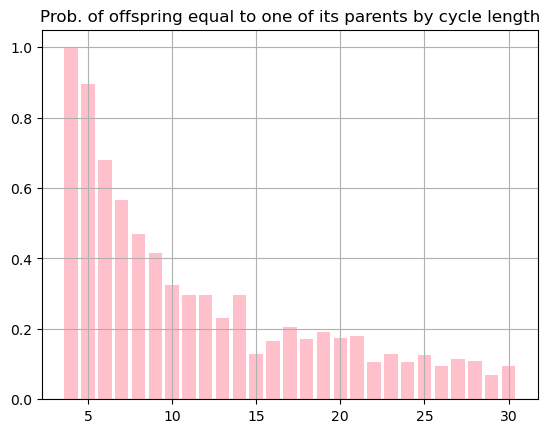

In [84]:
def equivalent(c1,c2):
    i = 1
    j = (c2.index(c1[0])+1)%len(c2)
    while c1[i] == c2[j] and i != 0:
        i = (i+1)%len(c1)
        j = (j+1)%len(c2)
    return (i==0)

def random_cycle(l):
    c = [i for i in range(l)]
    num_trans = random.randint(100,200)
    for count in range(num_trans):
        i = random.randint(0,l-1)
        j = random.randint(0,l-1) #do allow for i == j, since it helps to fight periodicity
        temp = c[i]
        c[i] = c[j]
        c[j] = temp
    return c

lengths = [l for l in range(4,31)]
fracs = []
for l in lengths:
    eq_count = 0
    trials = 200
    for trial in range(trials):
        c1 = random_cycle(l)
        c2 = random_cycle(l)
        c = crossover(c1,c2,0)
        if ( equivalent(c,c1) or equivalent(c,c2) ):
            eq_count += 1
    fracs.append(eq_count/trials)

plt.grid()
plt.bar(lengths,fracs, color='pink')
plt.title("Prob. of offspring equal to one of its parents by cycle length")

In [85]:
def trans_mutate(c):
    i = random.randint(0,len(c)-1)
    j = random.randint(0,len(c)-1)
    temp = c[i]
    c[i] = c[j]
    c[j] = temp
    return c

### Solutions

In [86]:
class TSP_Solutions_Population():
    def __init__(self, cities, pop_size, survival_rate = 0.5):
        self.pop_size = pop_size
        self.cities = cities
        self.cycles = [random_cycle(cities) for i in range(pop_size)]
        self.survival_rate = survival_rate
        
        self.best_solution = cities*[0] #best solution ever encountered
        self.best_dist = np.inf
        
    def reset(self):
        self.cycles = [random_cycle(self.cities) for i in range(self.pop_size)]

    def evolve_solutions(self, g, num_generations, prob_crossover_mutation = 0.001, prob_trans_mutation = 0.01):
        avg_dist_history = []
        bst_dist_history = []
        cutoff = int(self.survival_rate*self.pop_size)
        
        for generation in range(num_generations):
            
            #evaluate each member
            dist = np.array([g.cycle_length(cycle) for cycle in self.cycles])

            #sort from best to worst
            ind = np.argsort(dist)
            dist = dist[ind]
            self.cycles = [self.cycles[i] for i in ind]
            
            avg_dist_history.append(np.mean(dist))
            bst_dist_history.append(dist[0])
            #print(dist[0], self.best_dist)
            if dist[0]<self.best_dist:
                self.best_dist = dist[0]
                self.best_solution = list(np.copy(np.array(self.cycles[0])))
                #print(g.cycle_length(self.best_solution) == self.best_dist)

            #print(dist)
            
            #choose crossover parents and generate
            dist = dist[:cutoff] #select only the better chromosomes for reproduction
            if np.std(dist) > 0.01: #standarize
                #p = np.exp( -self.beta*(dist-np.mean(dist))/np.std(dist) )
                p = cutoff - np.arange(cutoff)
            else:
                p = np.ones( self.pop_size )
            #print(p/np.sum(p))
            cmf = np.cumsum(p/np.sum(p))
            
            parent_index = []
            for i in range(2*(self.pop_size-cutoff)):
                r = random.random()
                parent_index.append(np.where(cmf>=r)[0][0])
            new_cycles = []
            for j in range(0,2*(self.pop_size-cutoff),2):
                new_cycles.append(crossover(self.cycles[parent_index[j]], self.cycles[parent_index[j+1]], prob_crossover_mutation))
            
            #mutate new cycles and replace the population            
            self.cycles = self.cycles[:cutoff]
            
            for cycle in new_cycles:
                if random.random() < prob_trans_mutation:
                    self.cycles.append(trans_mutate(cycle))
                else:
                    self.cycles.append(cycle)
        return avg_dist_history, bst_dist_history

    def plot_evolution(self, g, num_generations, prob_crossover_mutation = 0.001, prob_trans_mutation = 0.001):
        avg_dist_history, bst_dist_history = self.evolve_solutions(g, num_generations, prob_crossover_mutation, prob_trans_mutation)
        plt.plot(np.arange(1,num_generations), avg_dist_history[1::], color = "orange", alpha = 0.25,label ="average distance")
        plt.plot(np.arange(1,num_generations), bst_dist_history[1::], color = "blue", alpha = 0.25,label="best distance")
        plt.xlabel("generation number")
        plt.ylabel("cycle distance")
        plt.legend()
        self.reset()

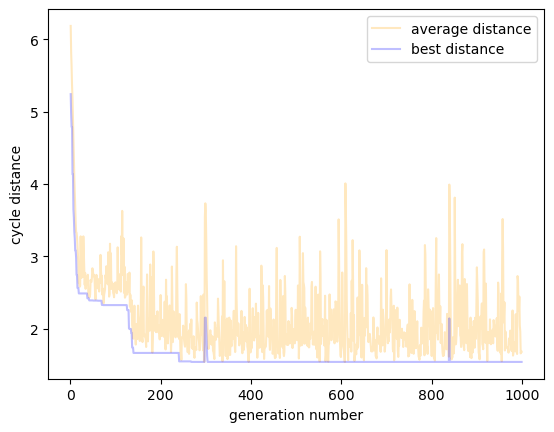

In [87]:
g = Circular_Graph(20)
population = TSP_Solutions_Population(cities = 20, pop_size = 40, survival_rate = 0.5)
population.plot_evolution(g,1000, prob_crossover_mutation = 0.1, prob_trans_mutation = 0.1)

The sharp falls in the best distance curve indicate the moments where a better solution was encountered by means of mutation. Notice that the average distance curve fluctuates wildly during the stages of stagnation in the best solution search - this is desirable as it indicates that the population is not entirely dominated by the best gene and that the mutation exploration is ongoing.

It is also interesting to see the kinks in the best distance curve. Apparently, the population sometimes loses track of the best solution and then settles down to a gene of similar quality, which is quite conforting as it is completely non-obvious whether the evolution is stable.

1.5438310983556809

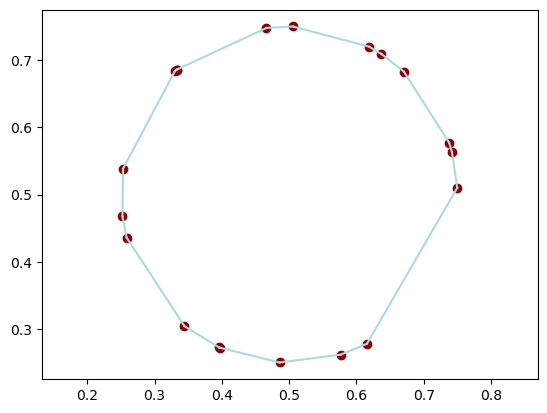

In [88]:
g.plot_cycle(population.best_solution)
g.cycle_length(population.best_solution)

We see that the algorithm works well for the test case.

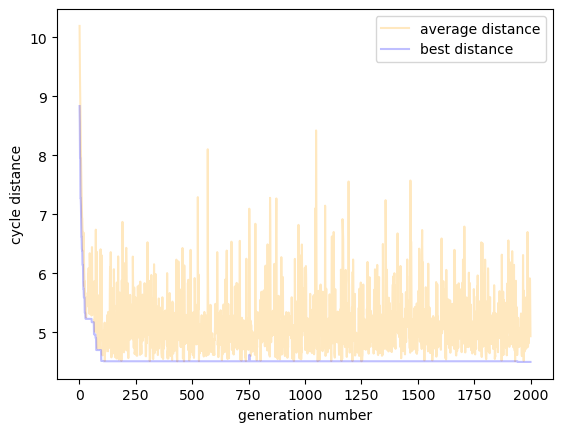

In [89]:
g = Graph(20)
population = TSP_Solutions_Population(cities = 20, pop_size = 40, survival_rate = 0.5)
population.plot_evolution(g,2000, prob_crossover_mutation = 0.1, prob_trans_mutation = 0.1)

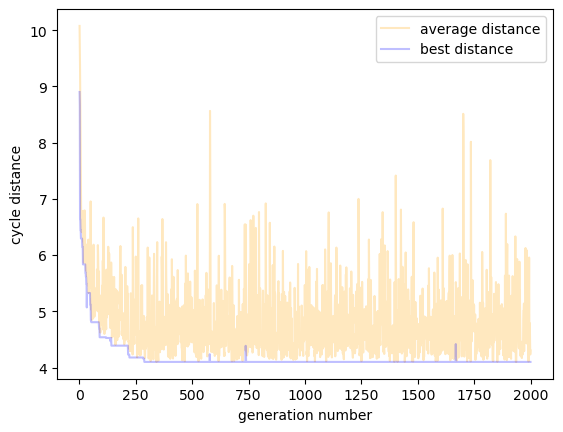

In [90]:
population.plot_evolution(g,2000, prob_crossover_mutation = 0.1, prob_trans_mutation = 0.1)

4.09991504259898

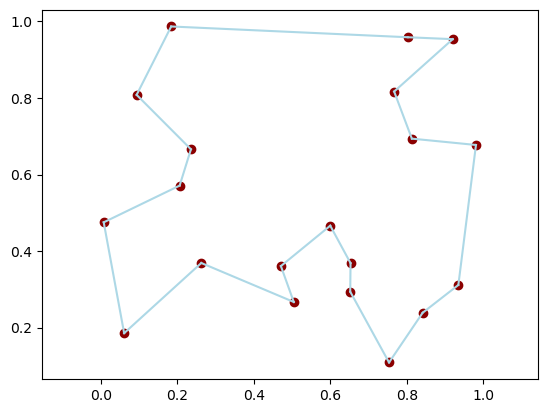

In [91]:
g.plot_cycle(population.best_solution)
g.cycle_length(population.best_solution)

### Convergence and stability - parameter choice considerations

If there are too few elements in the population, the evolution quickly becomes unstable - a prevalent quality domintes entirely the new generation, forcing it into a single element, the subsequent evolution of which seems then to be guided but by random mutatiations.

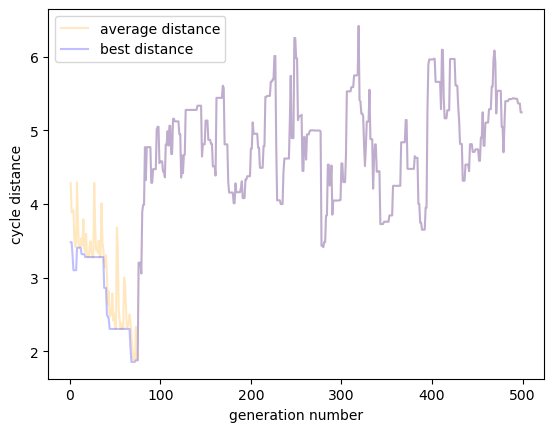

In [92]:
g = Circular_Graph(16)
population = TSP_Solutions_Population(cities = 16, pop_size = 12, survival_rate = 0.5)
population.plot_evolution(g,500, prob_crossover_mutation = 0.1, prob_trans_mutation = 0.1)

As we can see, the evolution did not reach the optimal solution before becoming unstable and hence the algorithm fails completely.

1.8575290155355322

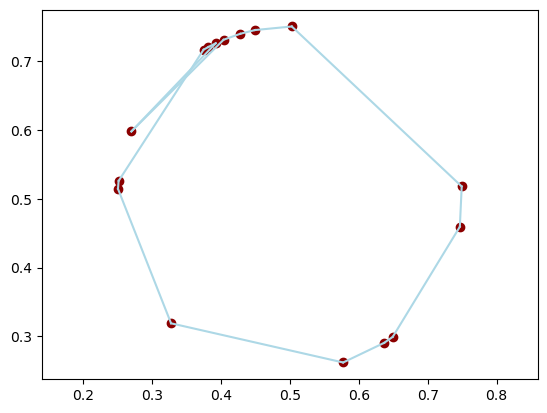

In [93]:
g.plot_cycle(population.best_solution)
g.cycle_length(population.best_solution)

### Scaling up

The algorithm fares quite well under scaling, provided we adjust the population size so as to protect from instability.

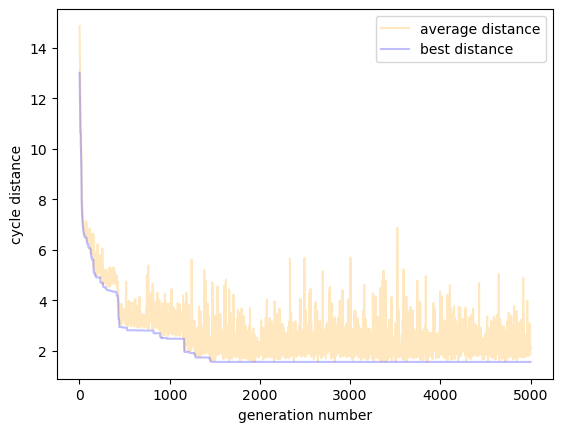

In [94]:
g = Circular_Graph(50)
population = TSP_Solutions_Population(cities = 50, pop_size = 100, survival_rate = 0.5)
population.plot_evolution(g, 5000, prob_crossover_mutation = 0.1, prob_trans_mutation = 0.1)

1.5654803789241556

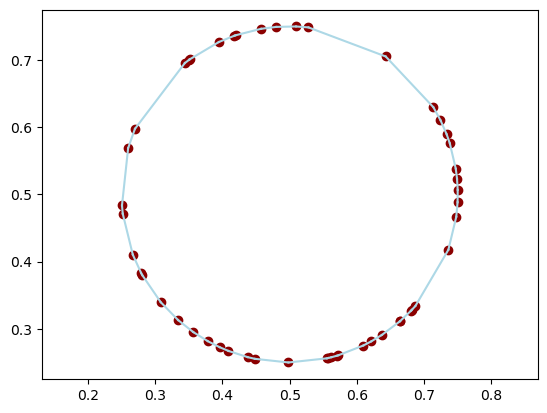

In [95]:
g.plot_cycle(population.best_solution)
g.cycle_length(population.best_solution)

The solutions for general graphs are reasonable albeit not necessarily perfect.

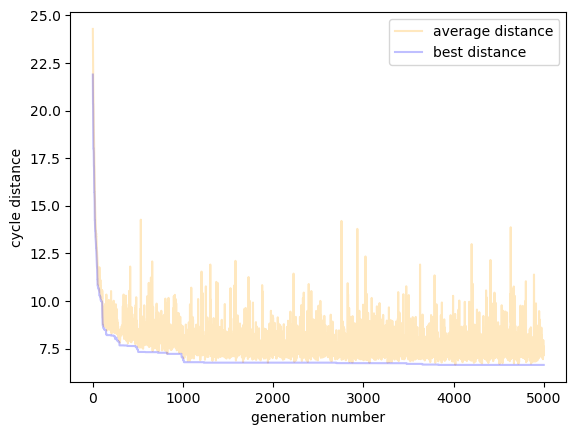

In [96]:
g = Graph(50)
population = TSP_Solutions_Population(cities = 50, pop_size = 100, survival_rate = 0.5)
population.plot_evolution(g, 5000, prob_crossover_mutation = 0.1, prob_trans_mutation = 0.1)

6.647943462381162

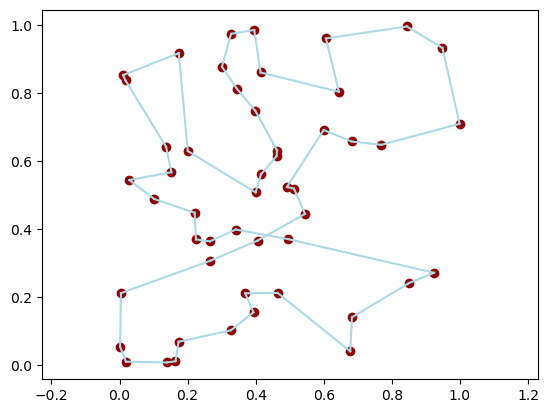

In [97]:
g.plot_cycle(population.best_solution)
g.cycle_length(population.best_solution)

However, as the number of cities increases, it is progressively more difficult to avoid having long chords in the circle example. Also, we can see in the above figure that line crossing occurs, and it is rarely optimal for the path to cross itself. Perhaphs this is the limitation of our method and a better heuristic could be derived basing on the renormalisation group approach and the multi-scale structure of the problem.